In [1]:
import matplotlib.pyplot as plt
import time

In [2]:
from common_functions import *

2022-12-05 17:09:36.926657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 17:09:37.641380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-05 17:09:37.641434: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-05 17:09:37.641441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [45]:
C = np.load('encodec_transformed_data/C.npy')
Cv = np.load('encodec_transformed_data/Cv.npy')
y = np.load('encodec_transformed_data/yC.npy')
yv = np.load('encodec_transformed_data/yCv.npy')
C = np.reshape(C,(-1,75,20))
Cv = np.reshape(Cv,(-1,75,20))
# C = np.transpose(C,axes=(0,3,2,1))
# Cv = np.transpose(Cv,axes=(0,3,2,1))

In [114]:
model = models.Sequential([
    layers.Input(shape=(75,20,1)),
    lq.layers.QuantConv2D(32, (3,3), activation='relu',input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    lq.layers.QuantConv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    lq.layers.QuantDense(128, activation='relu'),
    lq.layers.QuantDense(8),
])
lq.models.summary(model)

+sequential_25 stats-----------------------------------------------------------------------------------------+
| Layer                   Input prec.           Outputs  # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                               (bit)                        x 1       x 1     (kB)                          |
+------------------------------------------------------------------------------------------------------------+
| quant_conv2d_50                   1  (-1, 73, 18, 32)      288        32     0.16      378432            0 |
| max_pooling2d_34                  -   (-1, 36, 9, 32)        0         0        0           0            0 |
| batch_normalization_14            -   (-1, 36, 9, 32)        0        64     0.25           0            0 |
| quant_conv2d_51                   -   (-1, 34, 7, 64)        0     18496    72.25           0      4386816 |
| max_pooling2d_35                  -   (-1, 17, 3, 64)        0         0        0           0            0 |
|

In [115]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [116]:
train_acc = [];
test_acc = [];
elapsed_time = [];

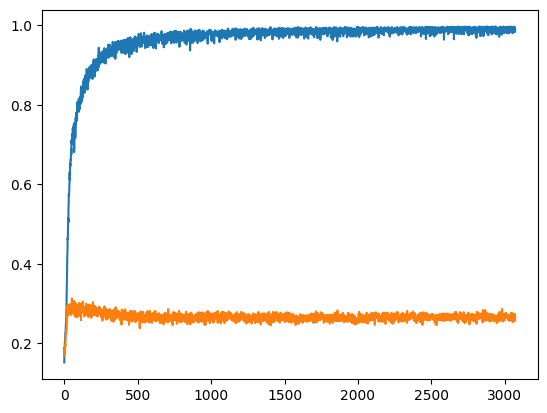

In [125]:
for i_iter in range(3000):
    t = time.process_time()
    train_history = model.fit(x=C, y=y, epochs=1, batch_size=64);
    elapsed_time.append(time.process_time()-t)
    _, test_acc_i = model.evaluate(x=Cv, y=yv)
    train_acc.append(train_history.history['accuracy'][0])
    test_acc.append(test_acc_i)
    display.clear_output()
plt.plot(np.vstack(train_acc))
plt.plot(np.vstack(test_acc))

In [126]:
print(np.median(elapsed_time), "seconds/iteration")
print(np.median(test_acc[-5:]), "test accuracy")

0.9301673905001735 seconds/iteration
0.26499998569488525 test accuracy
